In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv("C:/Users/fffkn/Downloads/Опрос__доверие_к_сервисам_знакомств.csv")
block_cols = df.columns[12:]

rename_map = {col: f'Q{i+1}' for i, col in enumerate(block_cols)}
df = df.rename(columns=rename_map)

def to_int(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'[1-5]', str(x))
    return int(m.group()) if m else np.nan

q_cols = list(rename_map.values())
df[q_cols] = df[q_cols].applymap(to_int)

df = df.dropna(subset=q_cols).reset_index(drop=True)

positive_q = ['Q9', 'Q12']
for col in positive_q:
    df[col] = df[col].apply(lambda x: 6 - x)



C:\Users\fffkn\AppData\Local\Temp\ipykernel_9976\1018445064.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[q_cols] = df[q_cols].applymap(to_int)


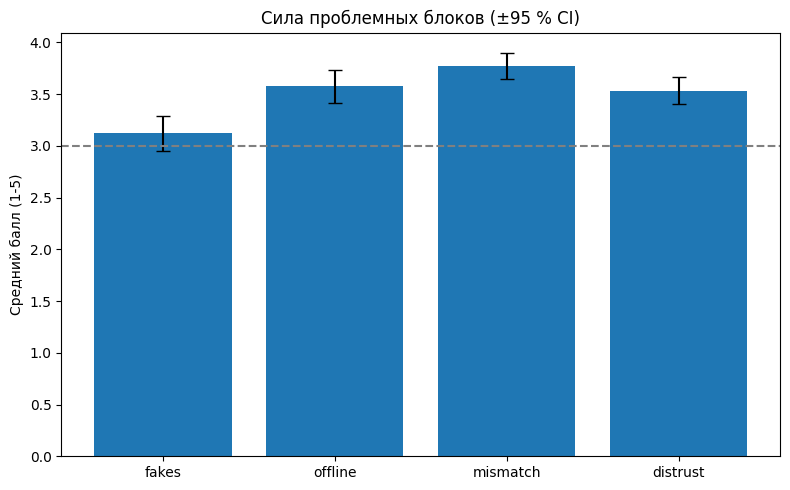

In [33]:



block_map = {
    'fakes': q_cols[0:3],
    'offline': q_cols[3:6],
    'mismatch': q_cols[6:9],
    'distrust': q_cols[9:13]
}

for name, cols in block_map.items():
    df[name] = df[cols].mean(axis=1)

blocks = list(block_map.keys())
means = [df[b].mean() for b in blocks]

se = [df[b].std(ddof=1)/np.sqrt(len(df)) for b in blocks]
ci = [1.977*s for s in se]

plt.figure(figsize=(8,5))
plt.bar(blocks, means, yerr=ci, capsize=5)
plt.axhline(3, linestyle='--', color='gray')
plt.ylabel('Средний балл (1-5)')
plt.title('Сила проблемных блоков (±95 % CI)')
plt.tight_layout(); plt.show()


In [34]:
means

[3.1214285714285714, 3.573809523809524, 3.7714285714285714, 3.532142857142857]

In [35]:
[(x-ci, x+ci) for x, ci in zip(means, ci)]

[(2.9523881902051983, 3.2904689526519446),
 (3.4137392787374417, 3.7338797688816063),
 (3.6436022222341364, 3.8992549206230063),
 (3.403238469255918, 3.661047245029796)]

In [ ]:
question_labels = ['Q1','Q2','Q3']

n = len(df)
rows = []

for q in question_labels:
    k = df[q].ge(4).sum()
    p_hat = k / n
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    moe = 1.96 * se
    ci_lo = p_hat - moe
    ci_hi = p_hat + moe
    rows.append([q, k, p_hat, se, ci_lo, ci_hi])

ci_table = pd.DataFrame(
    rows,
    columns=['Question', 'count', 'p', 'SE_p', 'CI_low', 'CI_high']
)

ci_table[['p','SE_p','CI_low','CI_high']] = (
    ci_table[['p','SE_p','CI_low','CI_high']].round(3)
)

print(ci_table.to_string(index=False))

Question  count     p  SE_p  CI_low  CI_high
      Q1     56 0.400 0.041   0.319    0.481
      Q2     44 0.314 0.039   0.237    0.391
      Q3     73 0.521 0.042   0.439    0.604


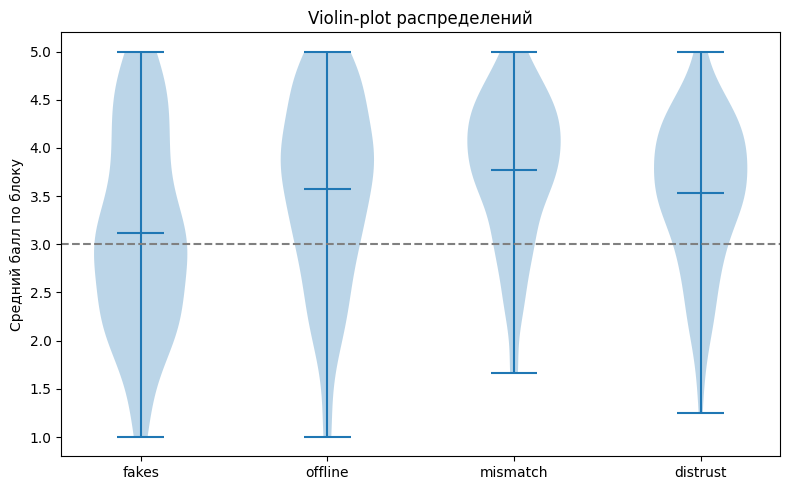

In [16]:

plt.figure(figsize=(8,5))
plt.violinplot([df[b] for b in blocks], showmeans=True)
plt.xticks(np.arange(1, len(blocks)+1), blocks)
plt.axhline(3, linestyle='--', color='gray')
plt.ylabel('Средний балл по блоку')
plt.title('Violin-plot распределений')
plt.tight_layout(); plt.show()

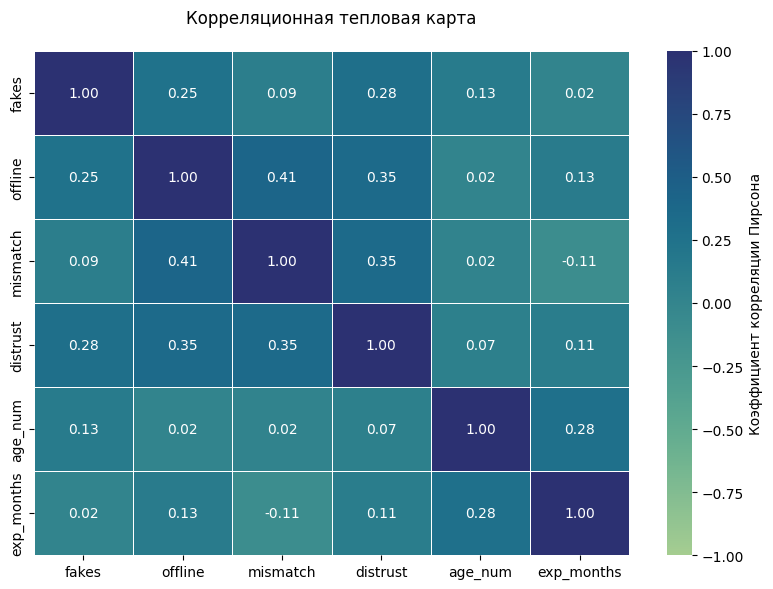

In [17]:
import seaborn as sns

df['age_num'] = pd.to_numeric(df['1. Ваш возраст'], errors='coerce')
exp_map = {'Менее месяца': 0.5, '1–6 месяцев': 3.5, '6–12 месяцев': 9.0, 'Более года': 18.0}
df['exp_months'] = df['3. Как долго вы пользуетесь (или пользовались) сервисами знакомств?'].map(exp_map)


corr_vars = ['fakes','offline','mismatch', 'distrust','age_num','exp_months']
corr = df[corr_vars].dropna().corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='crest', vmin=-1, vmax=1, linewidths=.5, cbar_kws={'label':'Коэффициент корреляции Пирсона'})
plt.title('Корреляционная тепловая карта', pad=20)
plt.tight_layout()
plt.show()

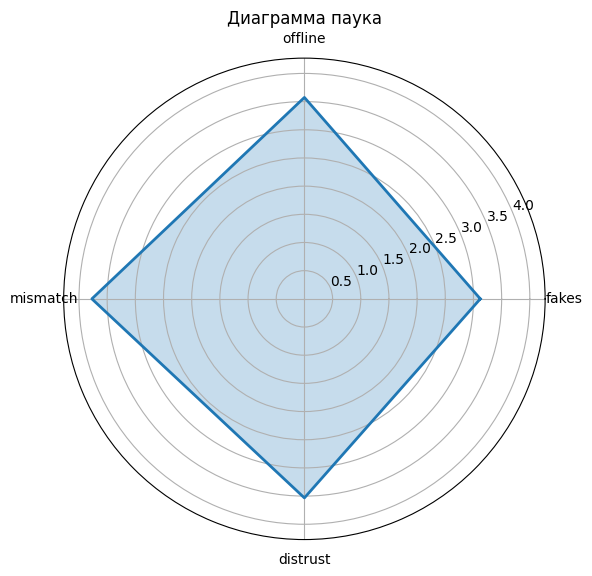

In [18]:
values = means + [means[0]]
labels = blocks + [blocks[0]]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=True)

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(angles[:-1] * 180/np.pi, blocks)
ax.set_rlim(0, max(values) + 0.5)
ax.set_title('Диаграмма паука')
plt.tight_layout()
plt.show()